# Load in Libraries

In [1]:
import numpy as np
from numpy import absolute
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as MSE

# Manage DataFrames
import pandas as pd

# Visualize
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

# Regression model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.model_selection import RepeatedKFold

# Normalize
from sklearn.preprocessing import StandardScaler

# Gridsearch

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

Load in Data and define x,y

In [2]:
df = pd.read_csv("Exercise2BusData.csv")


In [3]:
df = df.drop(['Arrival_time','Stop_id','Bus_id','Line_id'], axis=1)
df.head(10000)

,Arrival_delay,Dwell_time,Scheduled_travel_time,Upstream_stop_delay,Recurrent_delay
0,-23,0,39,-4,28.641509
1,168,0,39,181,27.880597
2,231,0,39,244,27.852941
3,150,17,39,143,27.826087
4,965,35,51,947,42.029412
...,...,...,...,...,...
2174,123,10,51,128,34.189873
2175,78,0,51,95,34.197531
2176,86,23,51,82,35.414634
2177,121,10,51,119,35.373494


<AxesSubplot:xlabel='Arrival_delay'>

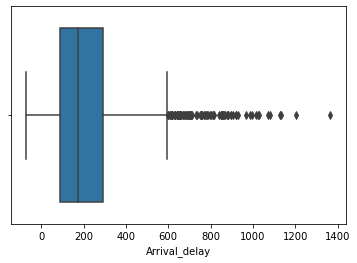

In [4]:
sns.boxplot(x=df['Arrival_delay'])

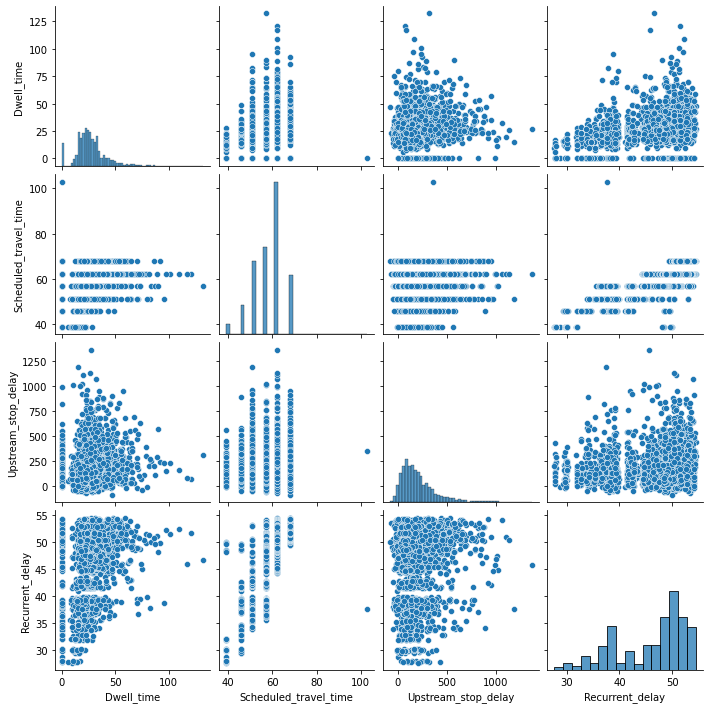

In [5]:
x = df.drop(['Arrival_delay'], axis=1)
y = df['Arrival_delay']

sns.pairplot(x)

In [6]:
n=42131
std2019=df['Arrival_delay'].std()
mean=df['Arrival_delay'].mean()

# Tried removing the outlier, did not result in a better fit
# outliers=[]
# for i in df['Arrival_delay']:
#    z=abs((i-mean)/std2019)
#    if z > 3:
#        outliers.append(i)
#        df.drop(df[df["Arrival_delay"]==i].index, inplace=True)
#        
# outliers=pd.DataFrame(outliers)
# outliers.describe()

In [7]:
x = df.drop(['Arrival_delay'], axis=1)
y = df['Arrival_delay']
# tried Feature Engineering 
# Did not result in a better fit
#df['Dwell_Scheduled_ratio'] = df['Dwell_time'] / df['Scheduled_travel_time']
#df['Upstream_Scheduled_ratio'] = df['Upstream_stop_delay'] / df['Scheduled_travel_time']
#df['Total_Upstream_Recurrent'] = df['Upstream_stop_delay'] + df['Recurrent_delay']

# Splitting
train_X, test_X, train_y, test_y = train_test_split(x, y,
                      test_size = 0.20, random_state = 123)

scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
test_X_scaled = scaler.transform(test_X)


In [8]:
param_grid = {
    'n_estimators': [2000], # Number of trees # Best 2000
    'max_depth': [1], # depth of each tree # Best 1
    'learning_rate': [0.03] # learning rate # Best 0.03
}
# creating the model
xgb_model = XGBRegressor()
# using the grid parameters
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, verbose=2, scoring='neg_mean_squared_error')
# grid search to the data
grid_search.fit(train_X_scaled, train_y)

# best parameters and best estimator from the grid search
best_params = grid_search.best_params_
best_xgb = xgb.XGBRegressor(learning_rate=best_params['learning_rate'], n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'])
best_xgb.fit(train_X, train_y)
#best_model = grid_search.best_estimator_

# Predict using the best model

# Compute mae, mse r2
pred_y = best_xgb.predict(test_X)
mae = mean_absolute_error(test_y, pred_y)
mse = mean_squared_error(test_y, pred_y)
r2 = r2_score(test_y, pred_y)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
# Print the best parameters
print("Best Parameters:", best_params)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .learning_rate=0.03, max_depth=1, n_estimators=2000; total time=   5.2s
[CV] END .learning_rate=0.03, max_depth=1, n_estimators=2000; total time=   2.5s
[CV] END .learning_rate=0.03, max_depth=1, n_estimators=2000; total time=   2.2s
[CV] END .learning_rate=0.03, max_depth=1, n_estimators=2000; total time=   4.6s
[CV] END .learning_rate=0.03, max_depth=1, n_estimators=2000; total time=   3.7s
Mean Absolute Error: 10.806674963700662
Mean Squared Error: 207.76410446479105
R-squared: 0.9937010429716286
Best Parameters: {'learning_rate': 0.03, 'max_depth': 1, 'n_estimators': 2000}


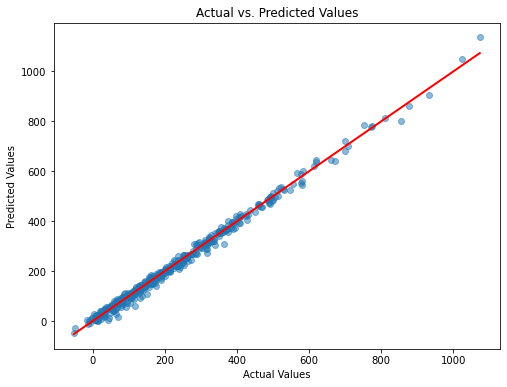

In [9]:
pred=pred_y
# Create a scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(test_y, pred, alpha=0.5)  # Plot actual vs. predicted values

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], linestyle='-', color='red', lw=2)

# Show the plot
plt.show()